In [23]:
from os.path import join, basename, splitext
from glob import glob
from dask import dataframe as dd
from matplotlib import rcParams
import pandas as pd
import dask
from collections import Counter
import pickle
import numpy as np
from datetime import datetime
import seaborn as sns

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from deep_aqi import ROOT


pd.set_option('expand_frame_repr', False)
pd.set_option('max_rows', 24)

In [2]:
def MAPE(data):
    data = data[data['True'] > 0]
    return np.mean(np.abs(data['True'] - data.Pred) / data['True'])

In [3]:
def MdAPE(data):
    data = data[data['True'] > 0]
    return np.median(np.abs(data['True'] - data.Pred) / data['True'])

In [4]:
def shift_target(data, number_of_days=1):
    timeshift = data.loc[:, target_column].reset_index()

    timeshift['PredictTime'] = timeshift.LocalDate
    timeshift.PredictTime = timeshift.PredictTime + pd.Timedelta(f'{number_of_days}D')
    timeshift = timeshift.rename(columns={target_column: f'{target_column}-{number_of_days*24}h'})
    timeshift.drop('LocalDate', axis=1, inplace=True)
    data.reset_index(inplace=True)
    data = pd.merge(data, timeshift, left_on='LocalDate', right_on='PredictTime', how='left')
    data.drop('PredictTime', axis=1, inplace=True)
    return data.sort_values('LocalDate').set_index('LocalDate')

In [5]:
def clean_outliers(data, sigma=10):
    # according to chebyshev inequality 10sigma covers 99% percent of data despite the distribution
    top = data[target_column].mean() + sigma * data[target_column].std()
    return data.loc[data[target_column] < top]

In [6]:
def prev_day_feature(data, fun, feature_name):
    feature = data.groupby(data.LocalDate.dt.date)[target_column].apply(fun)
    feature = pd.DataFrame(feature).reset_index()
    
    feature.LocalDate = pd.to_datetime(feature.LocalDate)
    feature.LocalDate = feature.LocalDate + pd.Timedelta('1D')
    feature.rename(columns={target_column: feature_name}, inplace=True)
    return pd.merge(df, feature, on='LocalDate', how='outer').sort_values('LocalDate').fillna(method='ffill')


In [7]:
def datetime_feature(data, feature_name):
    feature = getattr(data.LocalDate.dt, feature_name)
    dummies = pd.get_dummies(feature, prefix=feature_name)
    return pd.concat([data, dummies], axis=1)


In [8]:
PROCESSED_DATA = join(ROOT, 'data', 'processed')
INTERIM_DATA = join(ROOT, 'data', 'interim')
RAW_DATA = join(ROOT, 'data', 'raw')

In [9]:
file_path = join(PROCESSED_DATA, '88101.parquet')

data_source = pd.read_parquet(file_path)
target_column = data_source.columns[-1]

In [ ]:
to_concat = []
prediction_dicts = {}
for site_code, df in data_source.groupby(by='SiteCode'):
    df = clean_outliers(df)
    
    df = datetime_feature(df, 'hour')    
    df = datetime_feature(df, 'month')    
    df = datetime_feature(df, 'weekday')    
    
    df = prev_day_feature(df, np.mean, 'mean-24h')
    df = prev_day_feature(df, np.sum, 'sum-24h')
    df = prev_day_feature(df, np.min, 'min-24h')
    df = prev_day_feature(df, np.max, 'max-24h')
    df = prev_day_feature(df, np.std, 'std-24h')
    
    df = df.sort_values('LocalDate').set_index('LocalDate')
    
    df = shift_target(df, number_of_days=1)
    df = shift_target(df, number_of_days=2)
    df.dropna(inplace=True)
    
    Y = df.loc[:, target_column]
    X = df.drop([target_column, 'SiteCode'], axis=1)
    Y = MinMaxScaler().fit_transform(Y.values.reshape(-1, 1))
    Y = pd.Series(Y.flatten(), index=X.index)    
    
    SPLIT_POINT = int(0.8 * len(df))
    X_train, X_test = X.iloc[:SPLIT_POINT, :], X.iloc[SPLIT_POINT:, :]
    y_train, y_test = Y[:SPLIT_POINT], Y[SPLIT_POINT:]

    param_grid = {'bootstrap': [True],
                  'max_depth': [80, 90, 100, 110],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [3, 4, 5],
                  'min_samples_split': [8, 10, 12],
                  'n_estimators': [100, 200, 300, 500]
                 }
    
    model = GridSearchCV(estimator=RandomForestRegressor(),
                         param_grid=param_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=2)

    
#     model = RandomForestRegressor(n_jobs=-1,
#                                   n_estimators=1000,
#                                   verbose=2)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mdae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_ = np.mean(y_test)
    
    y_test = pd.DataFrame(y_test, columns=['True']).reset_index(drop=False)  
    y_pred = pd.DataFrame(y_pred, columns=['Pred'])    
    prediction = pd.concat([y_test, y_pred], axis=1).set_index('LocalDate')
    
    mape = MAPE(prediction)
    mdape = MdAPE(prediction)

    result = pd.DataFrame(index = [site_code],
                          data={'MAE': mae,
                                'MSE': mse,
                                'MdAE': mdae,
                                'R2': r2,
                                'MAPE': mape,
                                'MdAPE': mdape,
                                'MEAN': mean_,
                               })
    to_concat.append(result)
    prediction_dicts[site_code] = prediction
    break
results = pd.concat(to_concat)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


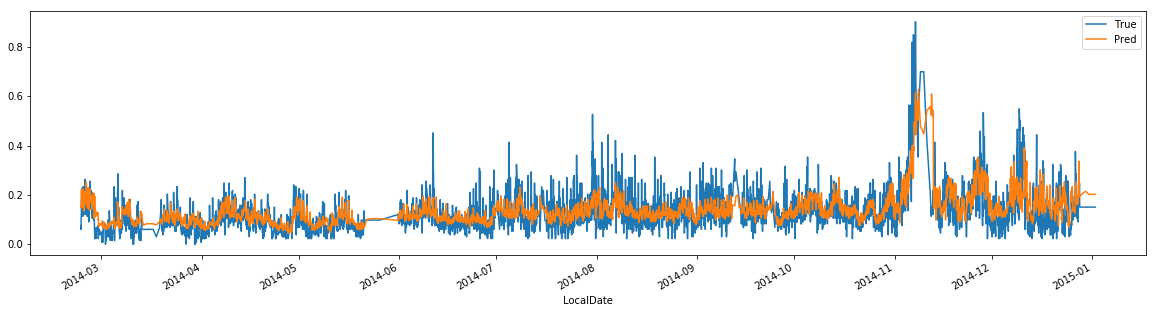

In [22]:
prediction = prediction_dicts['California_Fresno_5001.0']
prediction.plot(figsize=(20, 5))

In [21]:
results.sort_values('MAPE')

,MAE,MSE,MdAE,R2,MAPE,MdAPE,MEAN
California_Fresno_5001.0,0.042848,0.003842,0.031068,0.423989,0.46822,0.271904,0.129276


In [15]:
results.sort_values('MAPE')

,MAE,MSE,MdAE,R2,MAPE,MdAPE,MEAN
California_Fresno_5001.0,0.044261,0.004015,0.032331,0.398059,0.476947,0.278947,0.129276
